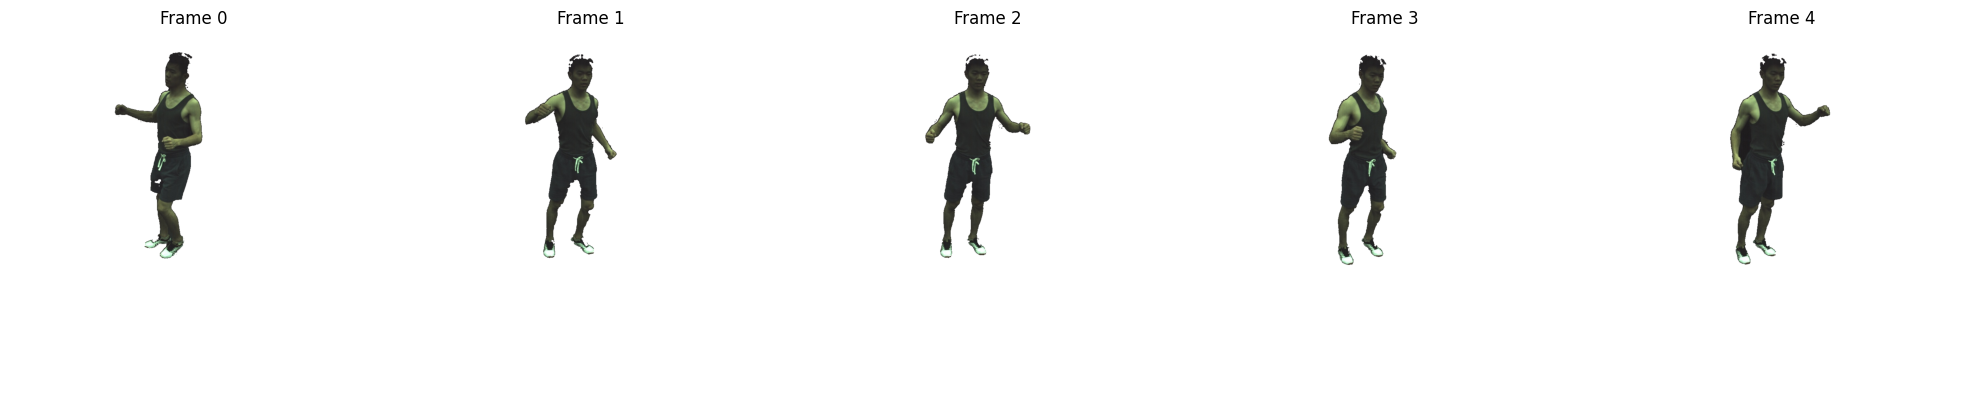

In [1]:
from datasets.dataset_zjumocap import ZJUMocapDataset
import numpy as np
import torch

dataset = ZJUMocapDataset(dataset_root='/home/liubingqi/work/Audio2Avatar/gaussian_avatar/data/zju_mocap', smpl_path='/home/liubingqi/work/liubingqi/SMPL_SMPLX/SMPL_models/smpl/SMPL_NEUTRAL.pkl')

data = dataset[0]
import matplotlib.pyplot as plt

n_frames = data['train'].video.shape[0]
plt.figure(figsize=(20, 4))

for i in range(n_frames):
    plt.subplot(1, n_frames, i+1)
    plt.imshow(data['train'].video[i])
    plt.title(f'Frame {i}')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [2]:
import smplx

def project_gaussians(gaussians, intrinsic, extrinsic):
    '''
    Project gaussians to image plane
    xyz: [B, N, 3]
    intrinsic: [3, 3]
    extrinsic: [4, 4]
    return: [B, N, 2]
    '''

    xyz = gaussians
    
    # Convert gaussian points from world coordinates to camera coordinates
    homogen_coord = torch.ones([xyz.shape[0], xyz.shape[1], 1], device=xyz.device, dtype=torch.float32)
    homogeneous_xyz = torch.cat([xyz, homogen_coord], dim=-1)  # [B, N, 4]
    
    # Apply extrinsic matrix
    cam_xyz = torch.matmul(extrinsic, homogeneous_xyz.transpose(-1, -2))  # [B, 4, N]
    cam_xyz = cam_xyz.transpose(-1, -2)[..., :3]  # [B, N, 3]
    
    # Apply intrinsic matrix
    projected_xy = torch.matmul(intrinsic, cam_xyz.transpose(-1, -2))  # [B, 3, N]
    projected_xy = projected_xy.transpose(-1, -2)
    projected_gaussians = projected_xy[..., :2] / projected_xy[..., 2:3]

    gaussians = projected_gaussians
    return gaussians

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
smpl_model = smplx.SMPL(
    model_path="/home/liubingqi/work/liubingqi/SMPL_SMPLX/SMPL_models/smpl/SMPL_NEUTRAL.pkl",
    batch_size=1,
    float_dtype=torch.float32
).to(device)

print(data['train'].smpl_parms['beta'].to(device).float())
print(data['train'].smpl_parms['body_pose'].reshape(-1, 24, 3)[:, 1:, :].to(device).float())
print(data['train'].smpl_parms['body_pose'].reshape(-1, 24, 3)[:, 0:1, :].to(device).float())

smpl_output = smpl_model(
    betas=data['train'].smpl_parms['beta'].to(device).float(),
    body_pose=data['train'].smpl_parms['body_pose'].reshape(-1, 24, 3)[:, 1:, :].to(device).float(),
    global_orient=data['train'].smpl_parms['body_pose'].reshape(-1, 24, 3)[:, 0:1, :].to(device).float(),
    # global_orient=torch.zeros_like(data['train'].smpl_parms['body_pose'].reshape(-1, 24, 3)[:, 0:1, :].to(device).float()),
    transl=data['train'].smpl_parms['trans'].to(device).float()
)

# # 使用R和T来变换顶点
# # 获取旋转矩阵R和平移向量T
# R = data['train'].smpl_parms['R'].to(device).float()  # 旋转矩阵
# T = data['train'].smpl_parms['trans'].to(device).float()  # 平移向量

# print(R.shape)
# print(T.shape)
# print(smpl_output.vertices.shape)

# # 应用变换到SMPL顶点
# # 首先应用旋转
# # 检查R和vertices的形状是否匹配
# # R应该是[batch_size, 3, 3]，vertices是[batch_size, 6890, 3]
# batch_size = smpl_output.vertices.shape[0]

# # 确保R的形状正确，如果是[1, 3, 3]但batch_size > 1，则需要扩展
# if R.shape[0] == 1 and batch_size > 1:
#     R = R.expand(batch_size, -1, -1)

# # 将vertices转换为[batch_size, 3, 6890]以便与R[batch_size, 3, 3]进行矩阵乘法
# vertices_transposed = smpl_output.vertices.transpose(1, 2)  # [batch_size, 3, 6890]

# # 执行批量矩阵乘法 [batch_size, 3, 3] @ [batch_size, 3, 6890] -> [batch_size, 3, 6890]
# rotated_vertices = torch.bmm(R, vertices_transposed)

# # 转换回原始形状 [batch_size, 3, 6890] -> [batch_size, 6890, 3]
# rotated_vertices = rotated_vertices.transpose(1, 2)

# # 确保T的形状正确，如果是[1, 3]但batch_size > 1，则需要扩展
# if T.shape[0] == 1 and batch_size > 1:
#     T = T.expand(batch_size, -1)

# # 应用平移 [batch_size, 6890, 3] + [batch_size, 1, 3]
# transformed_verts = rotated_vertices + T.unsqueeze(1)

# 更新顶点
verts = smpl_output.vertices

# # 同样应用变换到关节点
# transformed_joints = torch.matmul(R.unsqueeze(1), joints.unsqueeze(-1)).squeeze(-1)
# transformed_joints = transformed_joints + T.unsqueeze(1)
# joints = transformed_joints

# 可视化顶点
import trimesh
mesh = trimesh.Trimesh(verts[0].cpu().detach().numpy(), smpl_model.faces)
mesh.show()


tensor([[-0.2584, -0.0899,  0.0136,  0.0749,  0.0015,  0.0140,  0.0052,  0.0096,
         -0.0069,  0.0125],
        [-0.2584, -0.0899,  0.0136,  0.0749,  0.0015,  0.0140,  0.0052,  0.0096,
         -0.0069,  0.0125],
        [-0.2584, -0.0899,  0.0136,  0.0749,  0.0015,  0.0140,  0.0052,  0.0096,
         -0.0069,  0.0125],
        [-0.2584, -0.0899,  0.0136,  0.0749,  0.0015,  0.0140,  0.0052,  0.0096,
         -0.0069,  0.0125],
        [-0.2584, -0.0899,  0.0136,  0.0749,  0.0015,  0.0140,  0.0052,  0.0096,
         -0.0069,  0.0125]], device='cuda:0')
tensor([[[-3.5000e-01, -2.0318e-02,  1.0415e-01],
         [ 2.7520e-02, -1.1422e-01, -9.7663e-02],
         [-4.7702e-05, -1.5953e-03, -5.0397e-05],
         [ 5.9100e-01,  4.6878e-02, -1.4478e-01],
         [ 1.9189e-02, -7.7916e-02,  5.1292e-02],
         [-3.3175e-05, -2.9485e-03,  2.1750e-03],
         [-1.0615e-01, -5.1142e-04, -3.6245e-03],
         [-1.3866e-01, -6.2682e-02, -1.9723e-02],
         [-1.4772e-04, -2.8632e-03, -

计算投影点...
verts_incam shape: (5, 6890, 2)


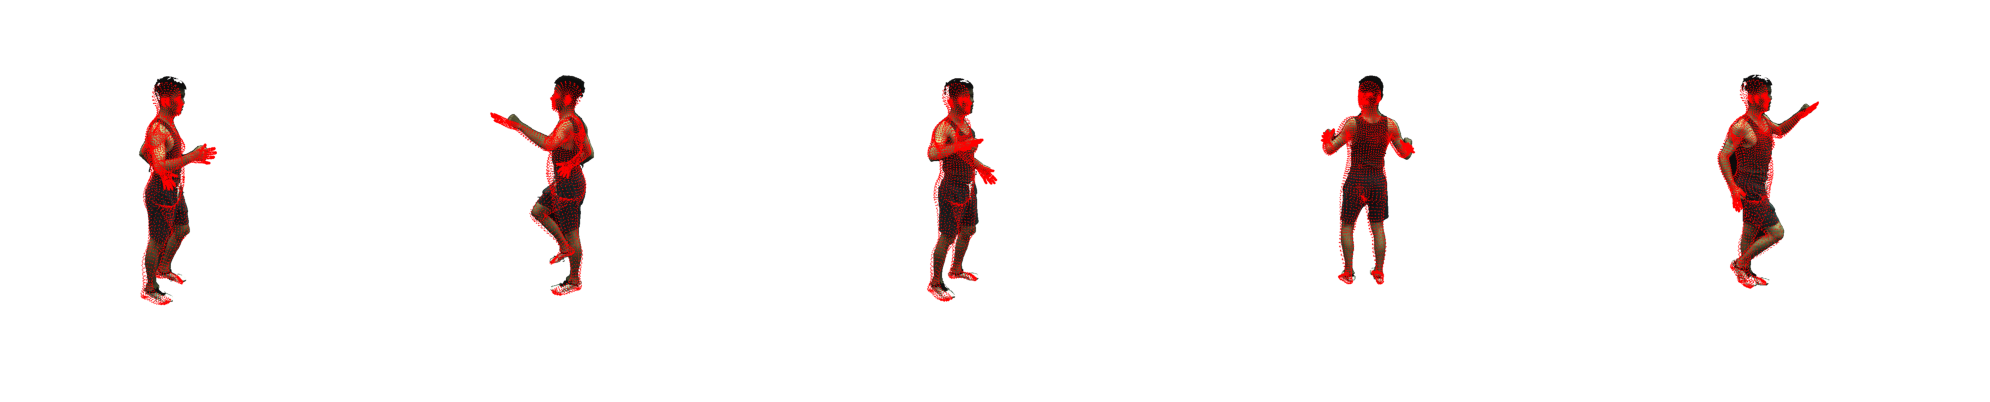

In [3]:
# 可视化投影结果
import cv2
import numpy as np

j = 0

# 计算投影点
print("计算投影点...")
verts_incam = project_gaussians(verts, 
                              data['train'].cam_parms['intrinsic'].unsqueeze(0).to(device), 
                              data['train'].cam_parms['extrinsic'].unsqueeze(0).to(device))[0].cpu().detach().numpy()
print("verts_incam shape:", verts_incam.shape)

plt.figure(figsize=(20, 5))
for j in range(5):
    plt.subplot(1, 5, j+1)
    
    # 使用data中的图像
    img = data['train'].video[j].numpy().copy()
    
    # 投影每个顶点
    for vertex_idx, (x, y) in enumerate(verts_incam[j, :, :2]):
        if 0 <= x < 1024 and 0 <= y < 1024:
            cv2.circle(img, (int(x), int(y)), 1, (1, 0, 0), -1)

    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()
